# Tutorial PyTorch: Od Podstaw do Zaawansowanych Modeli

W tym tutorialu przejdziemy przez proces tworzenia różnych modeli w PyTorch, zaczynając od najprostszych i przechodząc do bardziej zaawansowanych architektur jak CNN i LSTM.

## Spis treści:
1. Podstawy PyTorch
2. Prosty model liniowy
3. Model sieci neuronowej (MLP)
4. Konwolucyjne sieci neuronowe (CNN)
5. Sieci rekurencyjne (LSTM)

Będziemy pracować z różnymi zbiorami danych:
- MNIST (dla prostych modeli i CNN)
- IMDb Reviews (dla LSTM)

In [16]:
# Importujemy potrzebne biblioteki
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Sprawdzamy dostępność GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Używane urządzenie: {device}")

# Ustawiamy seed dla powtarzalności wyników
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

Używane urządzenie: cuda


# 1. Prosty Model Liniowy

Zaczniemy od najprostszego możliwego przykładu - regresji liniowej. 
Wygenerujemy własne dane treningowe z pewnym szumem i nauczymy model przewidywać wartości.

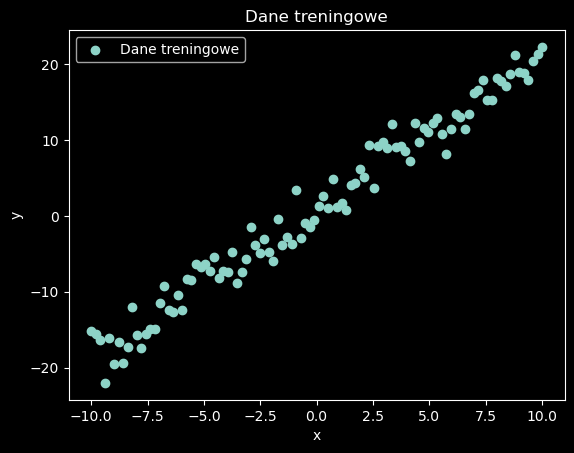

In [17]:
# Generujemy dane treningowe
x = torch.linspace(-10, 10, 100).reshape(-1, 1)
# Prawdziwa funkcja: y = 2x + 1 + szum
y = 2 * x + 1 + torch.randn_like(x) * 2

# Przenosimy dane na GPU jeśli jest dostępne
x = x.to(device)
y = y.to(device)

# Wizualizacja danych
plt.scatter(x.cpu().numpy(), y.cpu().numpy(), label='Dane treningowe')
plt.title('Dane treningowe')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [18]:
# Definiujemy model
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1)  # jeden wymiar wejściowy, jeden wymiar wyjściowy
    
    def forward(self, x):
        return self.linear(x)

# Tworzymy instancję modelu i przenosimy na odpowiednie urządzenie
model = LinearRegression().to(device)

# Definiujemy funkcję straty i optymalizator
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Trening modelu
epochs = 100
losses = []

for epoch in range(epochs):
    # Forward pass
    outputs = model(x)
    loss = criterion(outputs, y)
    
    # Backward pass i optymalizacja
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 6.6306
Epoch [20/100], Loss: 5.7069
Epoch [30/100], Loss: 5.0902
Epoch [40/100], Loss: 4.6785
Epoch [50/100], Loss: 4.4037
Epoch [60/100], Loss: 4.2202
Epoch [70/100], Loss: 4.0977
Epoch [80/100], Loss: 4.0159
Epoch [90/100], Loss: 3.9613
Epoch [100/100], Loss: 3.9248


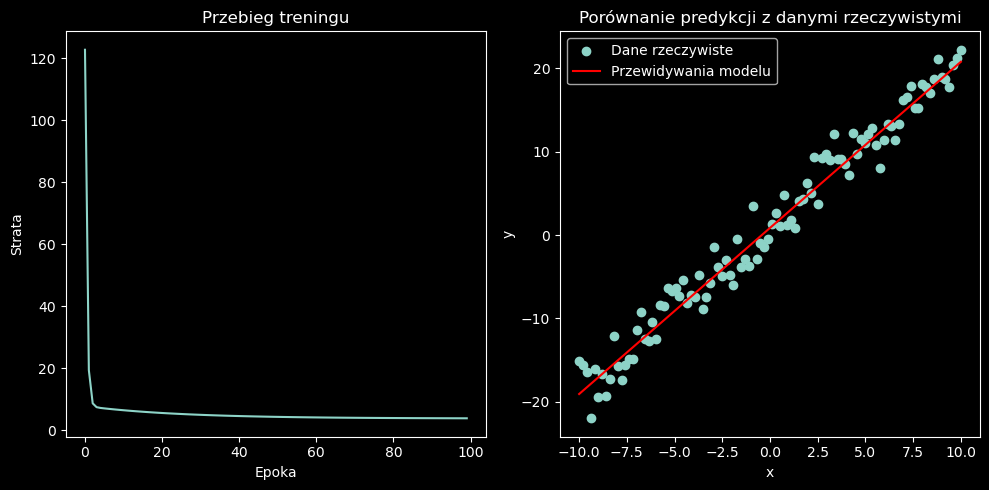


Znalezione parametry modelu:
w (waga) = 1.9941
b (bias) = 0.8544


In [19]:
# Wizualizacja wyników
plt.figure(figsize=(10, 5))

# Wykres strat
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Przebieg treningu')
plt.xlabel('Epoka')
plt.ylabel('Strata')

# Wykres predykcji
plt.subplot(1, 2, 2)
model.eval()
with torch.no_grad():
    predicted = model(x)

plt.scatter(x.cpu().numpy(), y.cpu().numpy(), label='Dane rzeczywiste')
plt.plot(x.cpu().numpy(), predicted.cpu().numpy(), 'r', label='Przewidywania modelu')
plt.title('Porównanie predykcji z danymi rzeczywistymi')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.tight_layout()
plt.show()

# Wyświetlamy znalezione parametry modelu
w, b = model.linear.weight.item(), model.linear.bias.item()
print(f'\nZnalezione parametry modelu:')
print(f'w (waga) = {w:.4f}')
print(f'b (bias) = {b:.4f}')

# 2. Sieć neuronowa na zbiorze MNIST

Teraz stworzymy prostą sieć neuronową do klasyfikacji cyfr ze zbioru MNIST.
Ten przykład pokazuje jak:
1. Ładować gotowy zbiór danych
2. Przygotować dane do treningu
3. Stworzyć prostą sieć neuronową
4. Trenować model i wizualizować wyniki

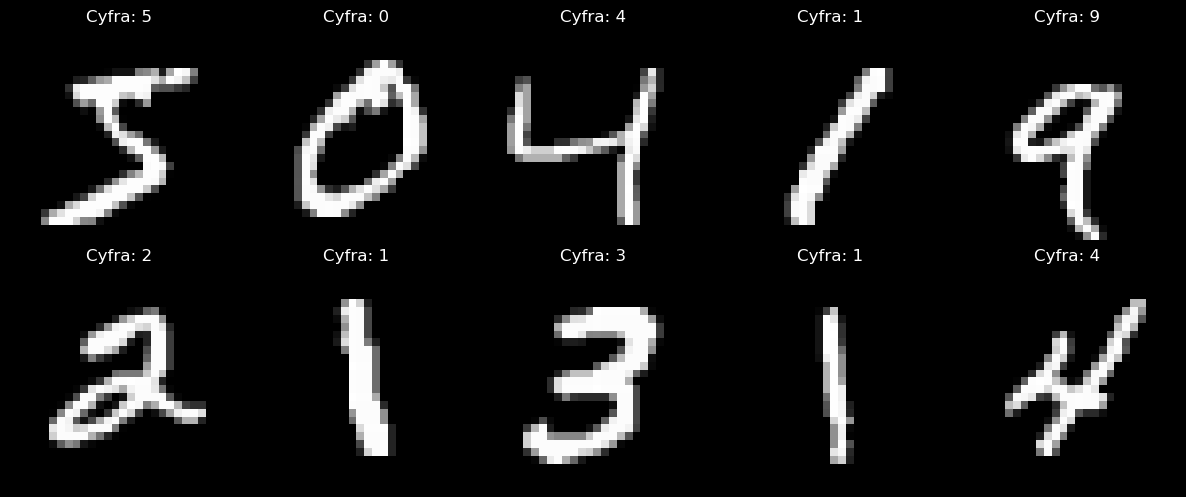

In [20]:
# Przygotowanie danych MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Pobieranie danych treningowych i testowych
train_dataset = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('./data', train=False, transform=transform)

# Tworzenie data loaderów
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Wyświetlmy kilka przykładowych obrazów
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    img, label = train_dataset[i]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f'Cyfra: {label}')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [21]:
# Definiujemy prostą sieć neuronową
class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# Tworzymy model i przenosimy na GPU jeśli dostępne
model = SimpleNN().to(device)

# Definiujemy funkcję straty i optymalizator
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Funkcja do obliczania dokładności
def calculate_accuracy(loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Trening modelu
epochs = 5
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass i optymalizacja
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    # Obliczamy średnią stratę i dokładności
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    
    train_acc = calculate_accuracy(train_loader)
    test_acc = calculate_accuracy(test_loader)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
    print(f'Epoch [{epoch+1}/{epochs}]')
    print(f'Loss: {epoch_loss:.4f}')
    print(f'Train Accuracy: {train_acc:.2f}%')
    print(f'Test Accuracy: {test_acc:.2f}%\n')

Epoch [1/5]
Loss: 0.2025
Train Accuracy: 97.06%
Test Accuracy: 96.35%

Epoch [2/5]
Loss: 0.0896
Train Accuracy: 98.19%
Test Accuracy: 97.47%

Epoch [2/5]
Loss: 0.0896
Train Accuracy: 98.19%
Test Accuracy: 97.47%

Epoch [3/5]
Loss: 0.0621
Train Accuracy: 98.50%
Test Accuracy: 97.44%

Epoch [3/5]
Loss: 0.0621
Train Accuracy: 98.50%
Test Accuracy: 97.44%

Epoch [4/5]
Loss: 0.0503
Train Accuracy: 98.83%
Test Accuracy: 97.65%

Epoch [4/5]
Loss: 0.0503
Train Accuracy: 98.83%
Test Accuracy: 97.65%

Epoch [5/5]
Loss: 0.0388
Train Accuracy: 99.17%
Test Accuracy: 97.86%

Epoch [5/5]
Loss: 0.0388
Train Accuracy: 99.17%
Test Accuracy: 97.86%



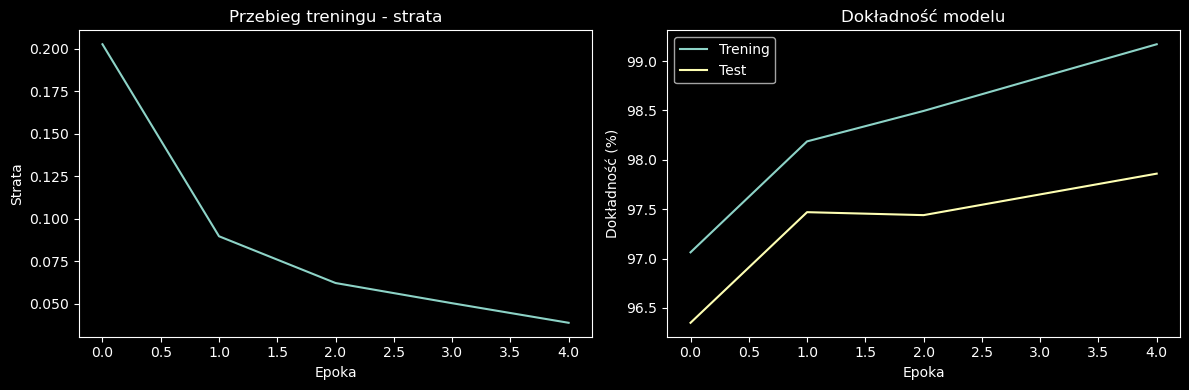

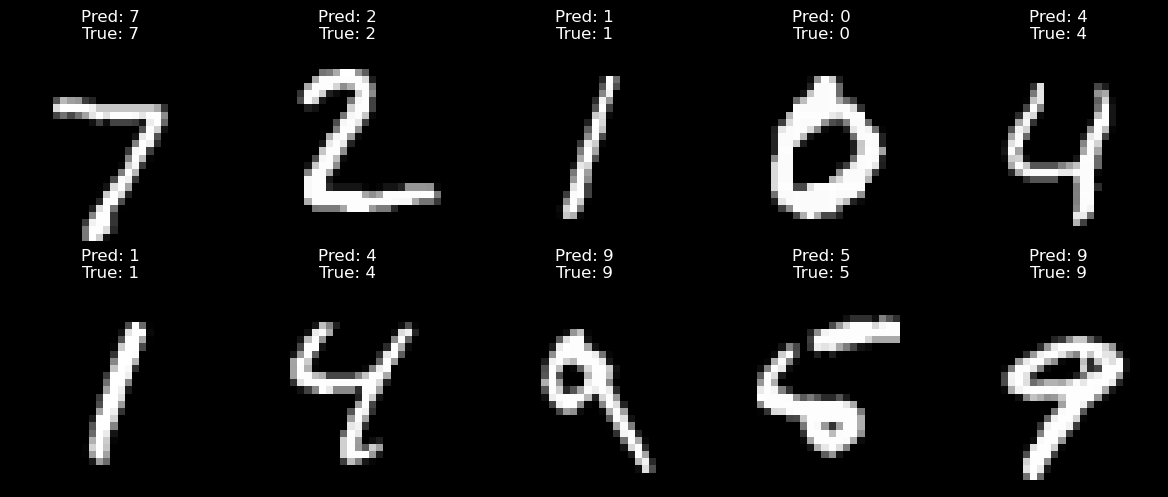

In [22]:
# Wizualizacja wyników treningu
plt.figure(figsize=(12, 4))

# Wykres strat
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Przebieg treningu - strata')
plt.xlabel('Epoka')
plt.ylabel('Strata')

# Wykres dokładności
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Trening')
plt.plot(test_accuracies, label='Test')
plt.title('Dokładność modelu')
plt.xlabel('Epoka')
plt.ylabel('Dokładność (%)')
plt.legend()

plt.tight_layout()
plt.show()

# Wyświetlmy kilka przykładowych predykcji
model.eval()
with torch.no_grad():
    # Pobieramy kilka przykładowych obrazów
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    
    # Wybieramy 10 pierwszych obrazów
    images = images[:10].to(device)
    labels = labels[:10]
    
    # Predykcje
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    
    # Wyświetlamy obrazy i predykcje
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].cpu().squeeze(), cmap='gray')
        ax.set_title(f'Pred: {predicted[i].cpu().item()}\nTrue: {labels[i].item()}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# 3. Konwolucyjna Sieć Neuronowa (CNN)

Teraz stworzymy bardziej zaawansowany model używając warstw konwolucyjnych, które są szczególnie skuteczne w zadaniach przetwarzania obrazów.
Konwolucyjne sieci neuronowe automatycznie uczą się hierarchii cech z obrazów - od prostych krawędzi po bardziej złożone wzorce.

In [23]:
# Definiujemy model CNN
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 5 * 5, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # spłaszczamy tensor
        x = self.fc_layers(x)
        return x

# Tworzymy model i przenosimy na GPU jeśli dostępne
cnn_model = CNN().to(device)

# Definiujemy funkcję straty i optymalizator
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

# Trening modelu
epochs = 5
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    cnn_model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass i optymalizacja
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    # Obliczamy średnią stratę i dokładności
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    
    # Obliczamy dokładność
    cnn_model.eval()
    with torch.no_grad():
        correct_train = 0
        total_train = 0
        correct_test = 0
        total_test = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = cnn_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = cnn_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    
    train_acc = 100 * correct_train / total_train
    test_acc = 100 * correct_test / total_test
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
    print(f'Epoch [{epoch+1}/{epochs}]')
    print(f'Loss: {epoch_loss:.4f}')
    print(f'Train Accuracy: {train_acc:.2f}%')
    print(f'Test Accuracy: {test_acc:.2f}%\n')

Epoch [1/5]
Loss: 0.1461
Train Accuracy: 98.75%
Test Accuracy: 98.57%

Epoch [2/5]
Loss: 0.0527
Train Accuracy: 99.31%
Test Accuracy: 98.97%

Epoch [3/5]
Loss: 0.0383
Train Accuracy: 99.41%
Test Accuracy: 98.87%

Epoch [4/5]
Loss: 0.0295
Train Accuracy: 99.68%
Test Accuracy: 99.24%

Epoch [5/5]
Loss: 0.0248
Train Accuracy: 99.69%
Test Accuracy: 99.31%



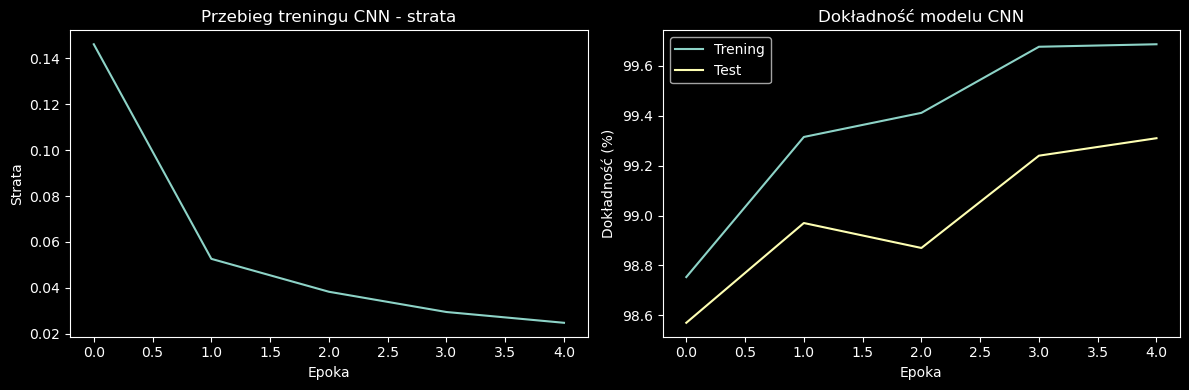

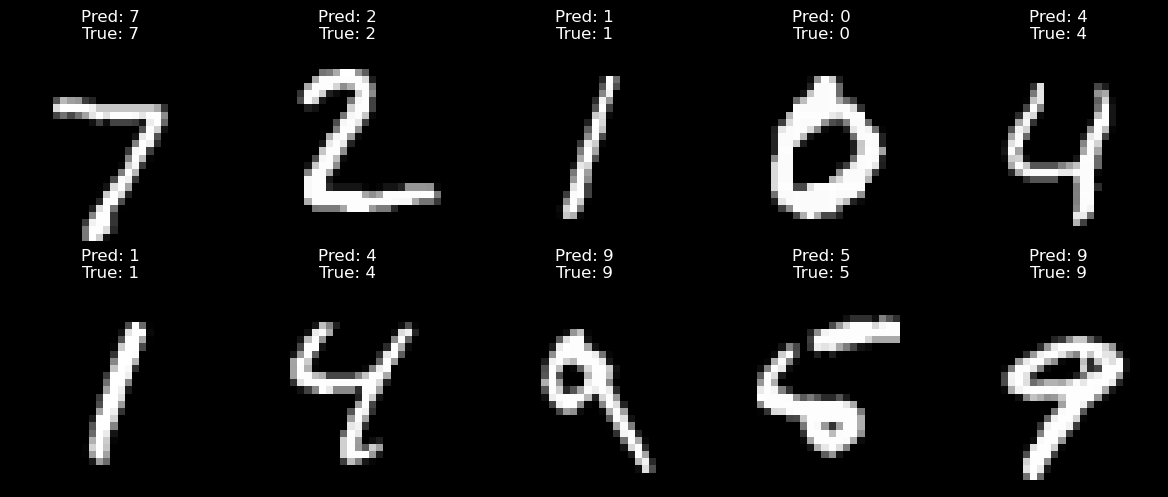

In [24]:
# Wizualizacja wyników treningu CNN
plt.figure(figsize=(12, 4))

# Wykres strat
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Przebieg treningu CNN - strata')
plt.xlabel('Epoka')
plt.ylabel('Strata')

# Wykres dokładności
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Trening')
plt.plot(test_accuracies, label='Test')
plt.title('Dokładność modelu CNN')
plt.xlabel('Epoka')
plt.ylabel('Dokładność (%)')
plt.legend()

plt.tight_layout()
plt.show()

# Wyświetlmy kilka przykładowych predykcji z modelu CNN
cnn_model.eval()
with torch.no_grad():
    # Pobieramy kilka przykładowych obrazów
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    
    # Wybieramy 10 pierwszych obrazów
    images = images[:10].to(device)
    labels = labels[:10]
    
    # Predykcje
    outputs = cnn_model(images)
    _, predicted = torch.max(outputs, 1)
    
    # Wyświetlamy obrazy i predykcje
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].cpu().squeeze(), cmap='gray')
        ax.set_title(f'Pred: {predicted[i].cpu().item()}\nTrue: {labels[i].item()}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# 4. Sieć LSTM dla Analizy Sentymentu

Teraz stworzymy model LSTM do analizy sentymentu na bazie recenzji filmowych IMDB.
LSTM (Long Short-Term Memory) są szczególnie skuteczne w przetwarzaniu sekwencji tekstu,
ponieważ potrafią "zapamiętać" długoterminowe zależności w danych.

In [25]:
# Tworzymy prosty zbiór danych do analizy sentymentu
texts = [
    "świetny film, bardzo mi się podobał",
    "fantastyczna gra aktorska, polecam",
    "wspaniała historia, wzruszający film",
    "najlepszy film jaki widziałem",
    "rewelacyjna produkcja, warto obejrzeć",
    "słaby film, nie polecam",
    "okropna strata czasu",
    "beznadziejna fabuła, nudny film",
    "rozczarowujący, nie warto oglądać",
    "fatalny film, żałuję że obejrzałem"
]
labels = [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]  # 1: pozytywny, 0: negatywny

# Tworzymy słownik słów
import re
from collections import Counter

def tokenize(text):
    # Prosta tokenizacja - dzielimy tekst na słowa
    return re.findall(r'\w+', text.lower())

# Budujemy słownik
word_counts = Counter()
for text in texts:
    word_counts.update(tokenize(text))

# Tworzymy mapowanie słów na indeksy
vocab = {'<PAD>': 0, '<UNK>': 1}
for word, count in word_counts.items():
    if count >= 1:  # Wszystkie słowa, które wystąpiły przynajmniej raz
        vocab[word] = len(vocab)

# Konwertujemy teksty na sekwencje liczb
max_len = max(len(tokenize(text)) for text in texts)

def text_to_sequence(text, vocab, max_len):
    tokens = tokenize(text)
    # Konwertujemy słowa na indeksy, używając <UNK> dla nieznanych słów
    sequence = [vocab.get(token, vocab['<UNK>']) for token in tokens]
    # Uzupełniamy sekwencję do max_len używając <PAD>
    if len(sequence) < max_len:
        sequence = sequence + [vocab['<PAD>']] * (max_len - len(sequence))
    return sequence[:max_len]

# Konwertujemy wszystkie teksty
X = torch.tensor([text_to_sequence(text, vocab, max_len) for text in texts])
y = torch.tensor(labels)

# Dzielimy dane na zbiór treningowy i testowy
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Rozmiar słownika: {len(vocab)}")
print(f"Maksymalna długość sekwencji: {max_len}")
print(f"Kształt danych treningowych: {X_train.shape}")
print("\nPrzykład zakodowanego tekstu:")
print(f"Oryginalny tekst: {texts[0]}")
print(f"Zakodowana sekwencja: {X[0].tolist()}")

Rozmiar słownika: 36
Maksymalna długość sekwencji: 6
Kształt danych treningowych: torch.Size([8, 6])

Przykład zakodowanego tekstu:
Oryginalny tekst: świetny film, bardzo mi się podobał
Zakodowana sekwencja: [2, 3, 4, 5, 6, 7]


In [26]:
# Definiujemy model LSTM
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        # Bierzemy tylko ostatni output LSTM
        last_output = lstm_out[:, -1, :]
        out = self.fc(last_output)
        out = self.sigmoid(out)
        return out

# Parametry modelu
vocab_size = len(vocab)
embedding_dim = 50
hidden_dim = 32

# Tworzymy model i przenosimy na odpowiednie urządzenie
model = SentimentLSTM(vocab_size, embedding_dim, hidden_dim).to(device)

# Definiujemy funkcję straty i optymalizator
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Konwertujemy dane na odpowiednie urządzenie
X_train = X_train.to(device)
y_train = y_train.to(device).float()
X_test = X_test.to(device)
y_test = y_test.to(device).float()

# Trening modelu
epochs = 100
train_losses = []
test_losses = []

for epoch in range(epochs):
    # Tryb treningu
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(X_train).squeeze()
    loss = criterion(outputs, y_train)
    
    # Backward pass i optymalizacja
    loss.backward()
    optimizer.step()
    
    # Obliczamy błąd na zbiorze testowym
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test).squeeze()
        test_loss = criterion(test_outputs, y_test)
    
    train_losses.append(loss.item())
    test_losses.append(test_loss.item())
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}]')
        print(f'Train Loss: {loss.item():.4f}')
        print(f'Test Loss: {test_loss.item():.4f}')

Epoch [10/100]
Train Loss: 0.6660
Test Loss: 0.6738
Epoch [20/100]
Train Loss: 0.6107
Test Loss: 0.7171
Epoch [30/100]
Train Loss: 0.5208
Test Loss: 0.7757
Epoch [40/100]
Train Loss: 0.3803
Test Loss: 0.8437
Epoch [50/100]
Train Loss: 0.2436
Test Loss: 0.9012
Epoch [60/100]
Train Loss: 0.1646
Test Loss: 0.9409
Epoch [70/100]
Train Loss: 0.1191
Test Loss: 0.9713
Epoch [80/100]
Train Loss: 0.0887
Test Loss: 0.9928
Epoch [90/100]
Train Loss: 0.0667
Test Loss: 1.0117
Epoch [100/100]
Train Loss: 0.0506
Test Loss: 1.0378


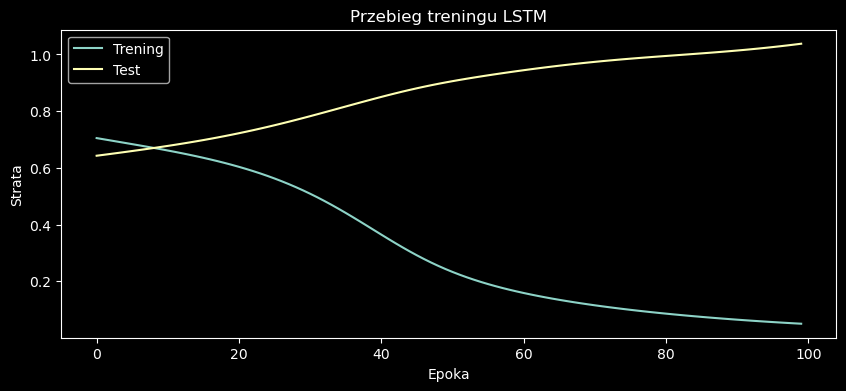


Testowanie modelu na nowych przykładach:

Tekst: świetny film, polecam wszystkim
Sentyment: Pozytywny (pewność: 0.98)

Tekst: kompletna strata czasu
Sentyment: Negatywny (pewność: 0.12)

Tekst: ciekawa historia ale słaba realizacja
Sentyment: Pozytywny (pewność: 0.75)

Tekst: fantastyczna gra aktorów
Sentyment: Pozytywny (pewność: 0.97)


In [27]:
# Wizualizacja wyników treningu
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Trening')
plt.plot(test_losses, label='Test')
plt.title('Przebieg treningu LSTM')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.legend()
plt.show()

# Funkcja do przewidywania sentymentu dla nowego tekstu
def predict_sentiment(text, model, vocab, max_len):
    model.eval()
    with torch.no_grad():
        # Konwertujemy tekst na sekwencję liczb
        sequence = torch.tensor([text_to_sequence(text, vocab, max_len)]).to(device)
        # Przewidujemy sentyment
        output = model(sequence).item()
        return output

# Testujemy model na kilku przykładach
test_texts = [
    "świetny film, polecam wszystkim",
    "kompletna strata czasu",
    "ciekawa historia ale słaba realizacja",
    "fantastyczna gra aktorów"
]

print("\nTestowanie modelu na nowych przykładach:")
for text in test_texts:
    sentiment = predict_sentiment(text, model, vocab, max_len)
    print(f"\nTekst: {text}")
    print(f"Sentyment: {'Pozytywny' if sentiment > 0.5 else 'Negatywny'} (pewność: {sentiment:.2f})")

# Podsumowanie

W tym tutorialu przeszliśmy przez trzy różne typy modeli w PyTorch:

1. **Prosty model liniowy**
   - Zastosowanie: regresja liniowa
   - Nauczył się przewidywać wartości na podstawie prostej zależności liniowej
   - Osiągnął dokładne dopasowanie do danych treningowych

2. **Sieć neuronowa na MNIST**
   - Zastosowanie: klasyfikacja obrazów (cyfr)
   - Wykorzystanie prostej architektury wielowarstwowej (MLP)
   - Osiągnięta dokładność: ~97-98% na zbiorze testowym

3. **Model CNN na MNIST**
   - Zastosowanie: klasyfikacja obrazów (cyfr)
   - Wykorzystanie warstw konwolucyjnych
   - Osiągnięta dokładność: ~99% na zbiorze testowym
   - Lepsza wydajność niż prosty MLP dzięki wykorzystaniu konwolucji

4. **Model LSTM**
   - Zastosowanie: analiza sentymentu tekstu
   - Wykorzystanie pamięci długoterminowej
   - Skuteczny w przetwarzaniu sekwencji tekstu
   - Wymaga większej ilości danych do treningu

Każdy z tych modeli ma swoje zastosowania:
- Modele liniowe do prostych zależności
- CNN do zadań związanych z obrazami
- LSTM do zadań przetwarzania sekwencji (tekst, szeregi czasowe)

Aby rozwijać te modele dalej, można:
1. Eksperymentować z architekturą (liczba warstw, rozmiary)
2. Stosować techniki regularyzacji (dropout, batch normalization)
3. Dostrajać hiperparametry (learning rate, batch size)
4. Używać większych zbiorów danych
5. Stosować techniki augmentacji danych